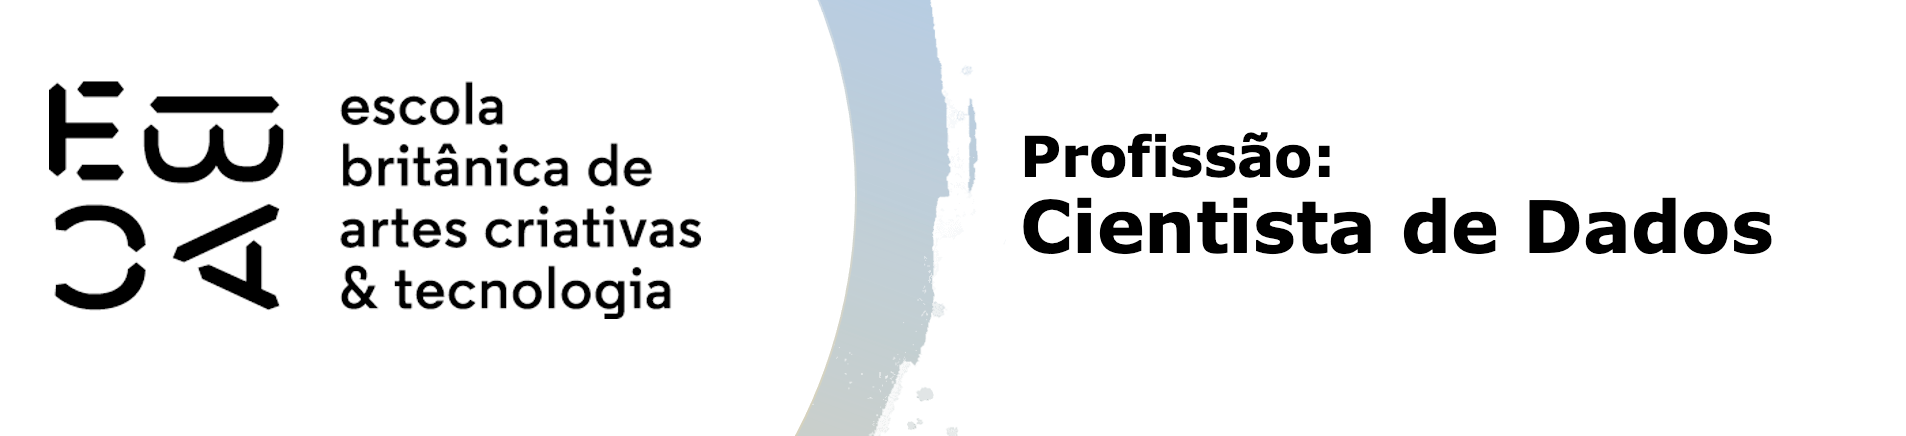

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# Carregando a Base de Dados
df = pd.read_feather('credit_scoring.ftr')
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [3]:
# Visualizando a estrutura da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Ordenando a base de dados
df = df.sort_values(by='data_ref')

In [5]:
# Definindo a data de corte
data_max = df['data_ref'].max()
data_corte = data_max - pd.DateOffset(months=3)

In [6]:
# Separando dados de treino e de validação
df_treino = df[df['data_ref'] < data_corte]
df_validacao = df[df['data_ref'] >= data_corte]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Visualizando datas
df_treino['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00']
Length: 11, dtype: datetime64[ns]

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

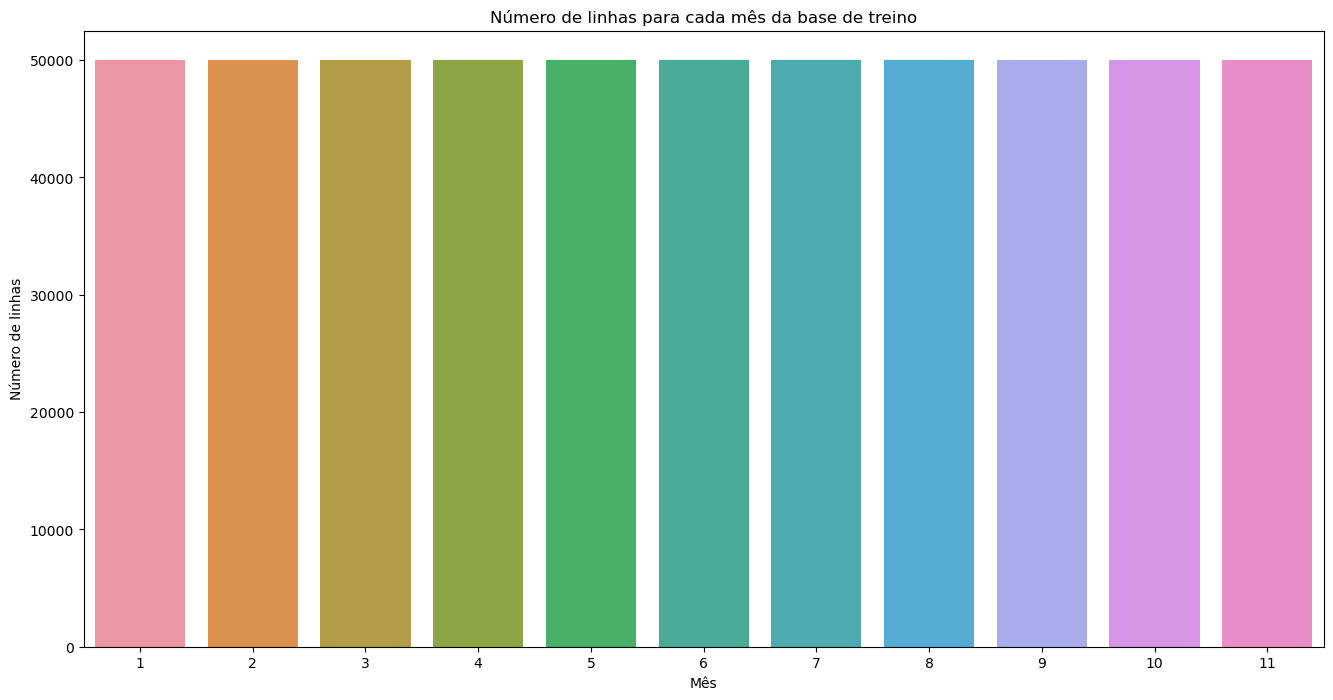

In [8]:
# Visualização gráfica número de linhas para cada mês
fig, ax = plt.subplots(figsize=(16,8))
mes = df_treino['data_ref'].dt.month
sns.countplot(data=df_treino, x=mes, ax=ax)
ax.set_xlabel('Mês')
ax.set_ylabel('Número de linhas')
ax.set_title('Número de linhas para cada mês da base de treino')

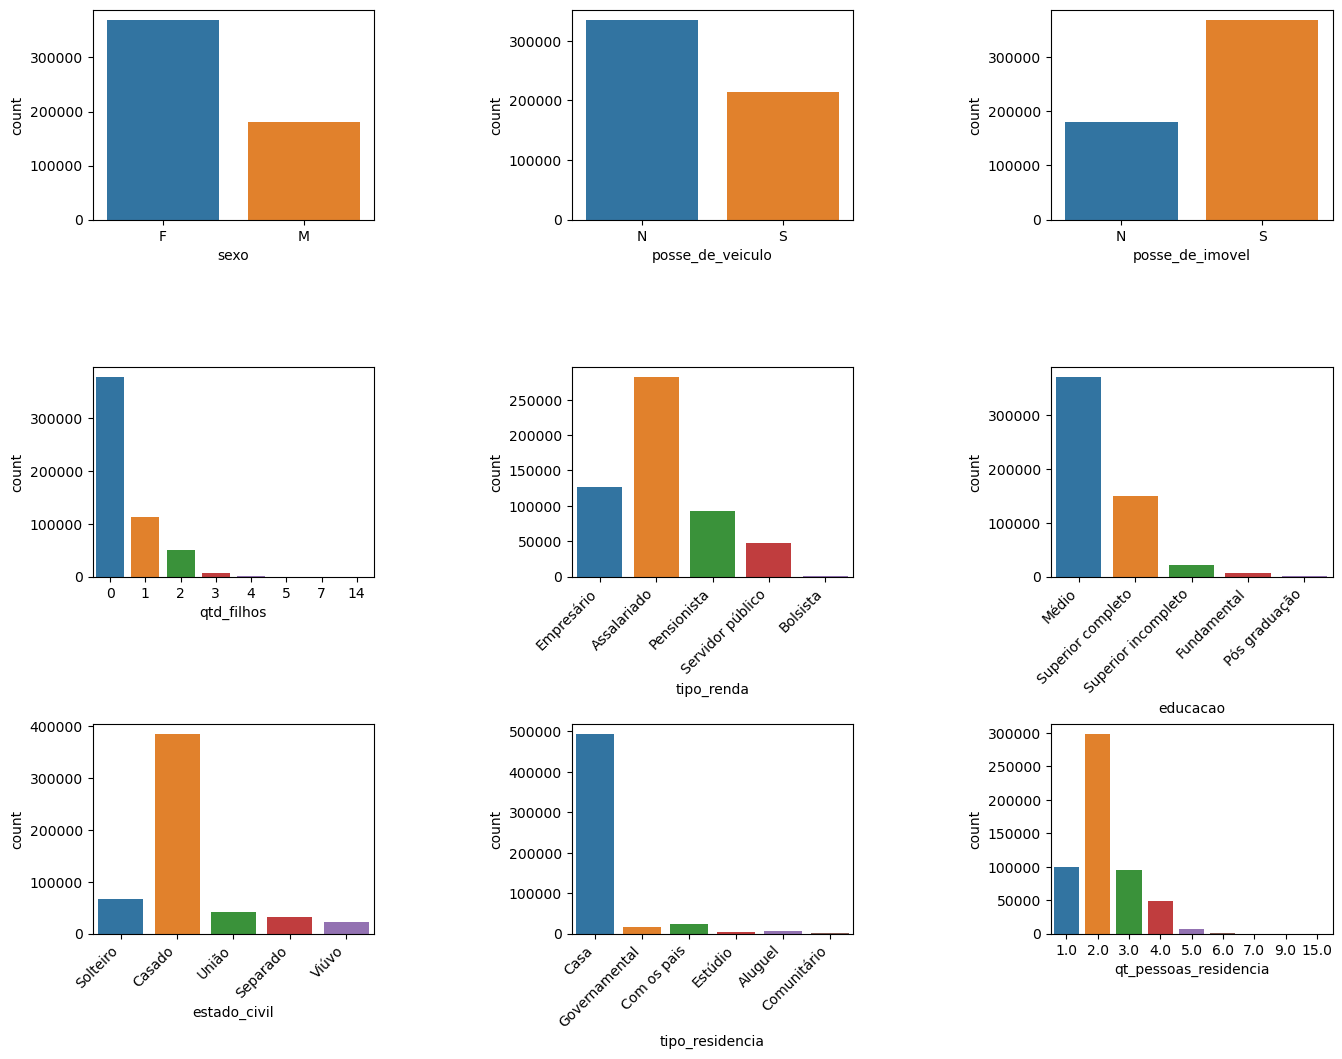

In [9]:
# Visualização Gráfica das Variáveis Qualitativas ou Quantitativas Discretas
plt.rc('figure', figsize=(16, 12))
fig, axes = plt.subplots(3, 3)

sns.countplot(ax = axes[0, 0], x='sexo', data=df_treino)
sns.countplot(ax = axes[0, 1], x='posse_de_veiculo', data=df_treino)
sns.countplot(ax = axes[0, 2], x='posse_de_imovel', data=df_treino)
sns.countplot(ax = axes[1, 0], x='qtd_filhos', data=df_treino) 
sns.countplot(ax = axes[1, 1], x='tipo_renda', data=df_treino)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[1, 2], x='educacao', data=df_treino)
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 0], x='estado_civil', data=df_treino)
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 1], x='tipo_residencia', data=df_treino)
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 2], x='qt_pessoas_residencia', data=df_treino)

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.7, hspace=0.7)

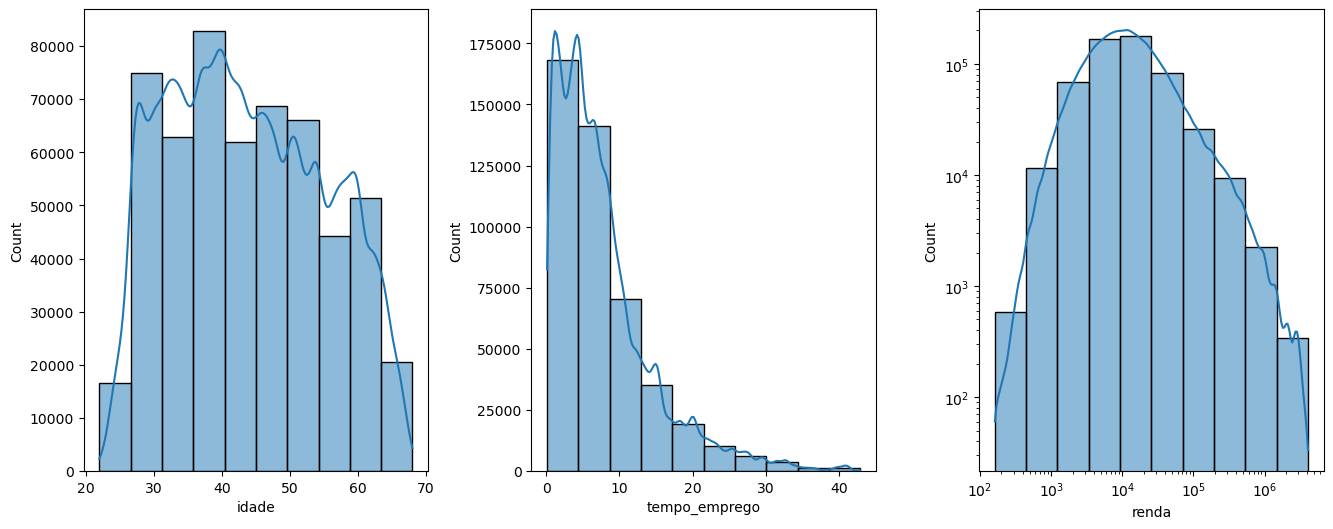

In [10]:
# Visualização Gráfica das Variáveis Quantitativas Contínuas via histograma
plt.rc('figure', figsize=(16, 6))
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(df_treino['idade'], bins=10, kde = True, ax = axes[0])
sns.histplot(df_treino['tempo_emprego'], bins=10, kde = True, ax = axes[1])
# Apresentando o gráfico de renda em escala logarítmica em função da distorção do eixo y em relação ao eixo x
sns.histplot(df_treino['renda'], bins=10, kde = True, log_scale=(True, True), ax = axes[2])

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.3)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

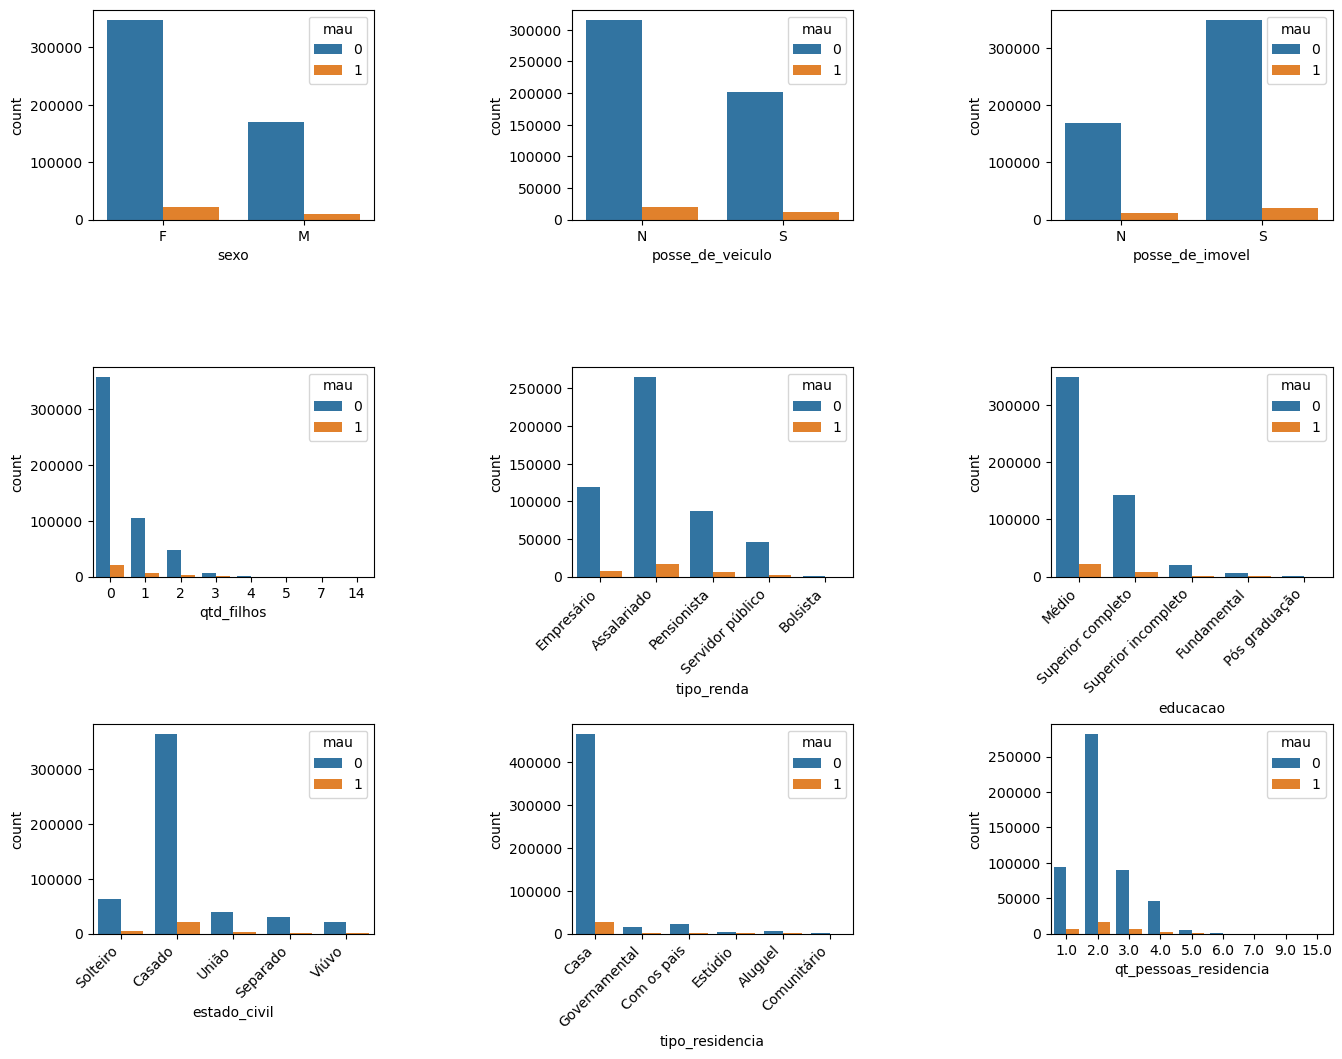

In [11]:
# Visualização Gráfica das Variáveis Qualitativas ou Quantitativas Discretas
plt.rc('figure', figsize=(16, 12))
fig, axes = plt.subplots(3, 3)

sns.countplot(ax = axes[0, 0], x='sexo', hue='mau', data=df_treino)
sns.countplot(ax = axes[0, 1], x='posse_de_veiculo', hue='mau', data=df_treino)
sns.countplot(ax = axes[0, 2], x='posse_de_imovel', hue='mau', data=df_treino)
sns.countplot(ax = axes[1, 0], x='qtd_filhos', hue='mau', data=df_treino) 
sns.countplot(ax = axes[1, 1], x='tipo_renda', hue='mau', data=df_treino)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[1, 2], x='educacao', hue='mau', data=df_treino)
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 0], x='estado_civil', hue='mau', data=df_treino)
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 1], x='tipo_residencia', hue='mau', data=df_treino)
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 2], x='qt_pessoas_residencia', hue='mau', data=df_treino)

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.7, hspace=0.7)

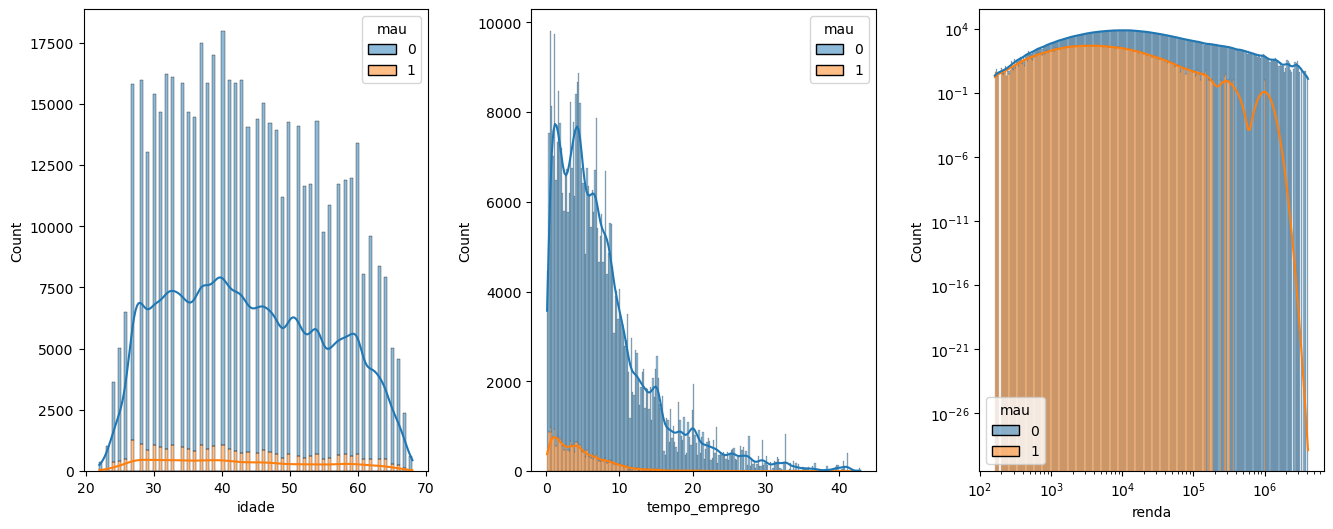

In [12]:
# Visualização Gráfica das Variáveis Quantitativas Contínuas via histograma
plt.rc('figure', figsize=(16, 6))
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(data=df_treino, x='idade', hue='mau', multiple='stack', kde = True, ax = axes[0])
sns.histplot(data=df_treino, x='tempo_emprego', hue='mau', multiple='stack', kde = True, ax = axes[1])
# Apresentando o gráfico de renda em escala logarítmica em função da distorção do eixo y em relação ao eixo x
sns.histplot(data=df_treino, x='renda', hue='mau', multiple='stack', kde = True, log_scale=(True, True), ax = axes[2])

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.3)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [13]:
# Removendo as variáveis 'data_ref' e 'index'
df_metadados = df_treino.drop(columns = ['data_ref', 'index'])

In [14]:
# Visualizando valores missing
df_metadados.isna().sum(axis=0)

sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            92488
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [16]:
# Tratando valores missing
media = df_metadados['tempo_emprego'].mean()
df_metadados['tempo_emprego'] = df_metadados['tempo_emprego'].copy().fillna(media)

In [17]:
# Visualizando distribuição da variável 'mau'
df_metadados.mau.value_counts()

mau
0    518213
1     31787
Name: count, dtype: int64

In [18]:
# Gerando metadados
metadados = pd.DataFrame(df_metadados.dtypes, columns=['dtype'])
metadados['nmissing'] = df_metadados.isna().sum()
metadados['valores_unicos'] = df_metadados.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [19]:
# Função para cálculo do IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [20]:
# Calculando o IV de cada variável
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_metadados[var],5,duplicates='drop'), df_metadados.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_metadados[var], df_metadados.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002323
posse_de_veiculo,object,0.0,2.0,covariavel,0.000043
posse_de_imovel,object,0.0,2.0,covariavel,0.009829
qtd_filhos,int64,0.0,8.0,covariavel,0.000145
tipo_renda,object,0.0,5.0,covariavel,0.010233
educacao,object,0.0,5.0,covariavel,0.003578
estado_civil,object,0.0,5.0,covariavel,0.001366
tipo_residencia,object,0.0,6.0,covariavel,0.003411
idade,int64,0.0,47.0,covariavel,0.018253
tempo_emprego,float64,0.0,3005.0,covariavel,0.282848


In [21]:
# Função para cálculo da biv_discreta
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [22]:
# Função para cálculo da biv_continua
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,348064,22063,0.059609,F,370127,0.000389,0.060372,0.058847,-2.758484,-2.744958,-2.772174,0.032845,0.046371,0.019155
M,170149,9724,0.054060,M,179873,0.000533,0.055105,0.053015,-2.862077,-2.841825,-2.882702,-0.070749,-0.050496,-0.091373


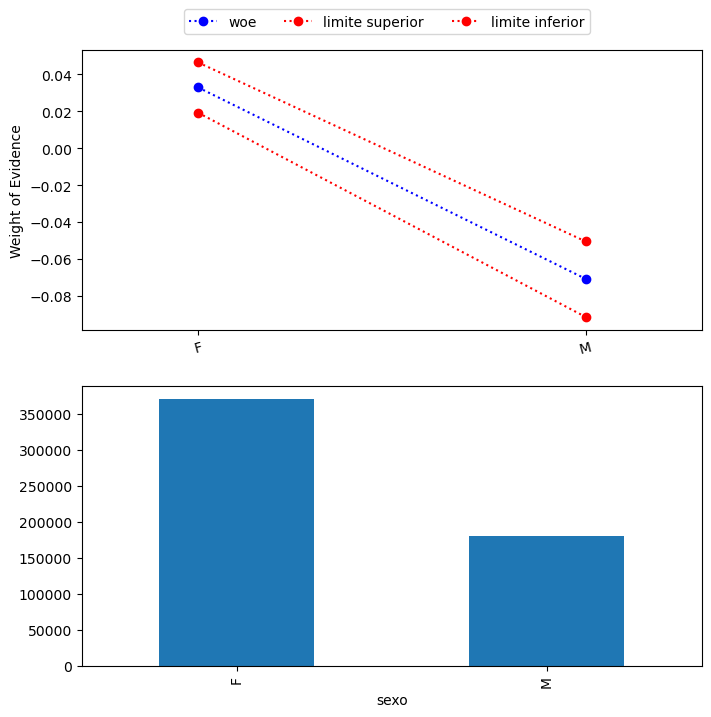

In [23]:
# Realizando o cálculo para a variável 'sexo'
pd.options.mode.copy_on_write = True 
biv_discreta('sexo', df_metadados)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,316160,19495,0.058080,N,335655,0.000404,0.058872,0.057289,-2.786090,-2.771718,-2.800647,0.005239,0.019611,-0.009318
S,202053,12292,0.057347,S,214345,0.000502,0.058331,0.056363,-2.799581,-2.781518,-2.817938,-0.008252,0.009811,-0.026609


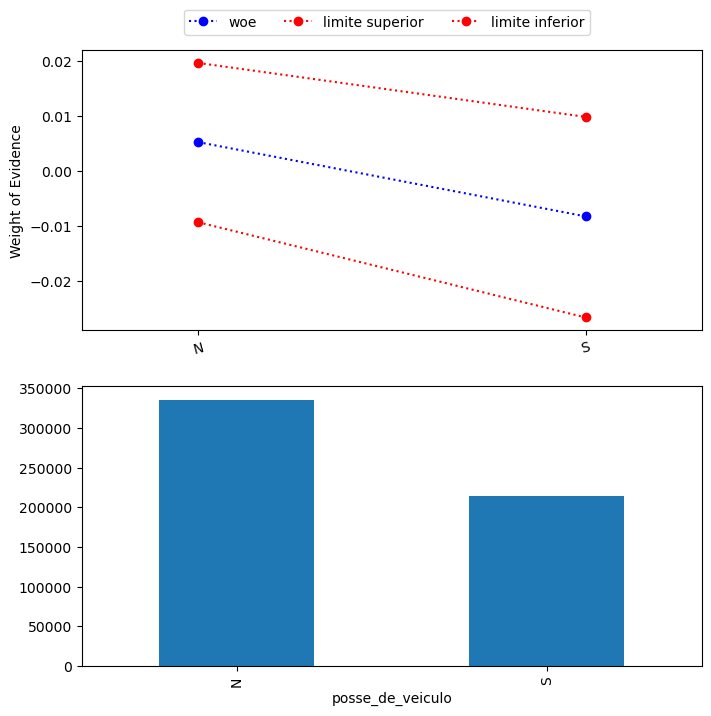

In [24]:
# Realizando o cálculo para a variável 'posse_de_veiculo'
biv_discreta('posse_de_veiculo', df_metadados)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,168867,11860,0.065624,N,180727,0.000582,0.066765,0.064482,-2.655940,-2.637470,-2.674711,0.135389,0.153859,0.116618
S,349346,19927,0.053963,S,369273,0.000372,0.054692,0.053234,-2.863987,-2.849802,-2.878354,-0.072658,-0.058473,-0.087025


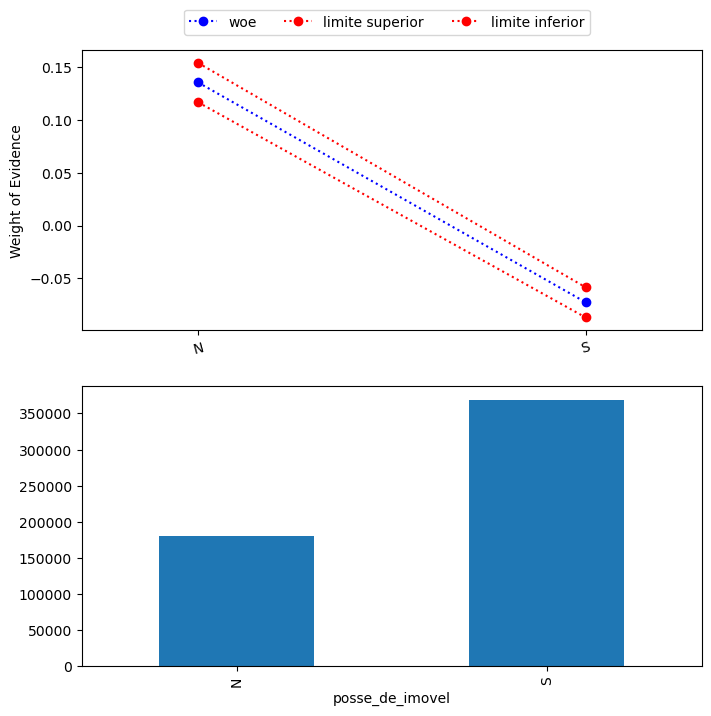

In [25]:
# Realizando o cálculo para a variável 'posse_de_imovel'
biv_discreta('posse_de_imovel', df_metadados)

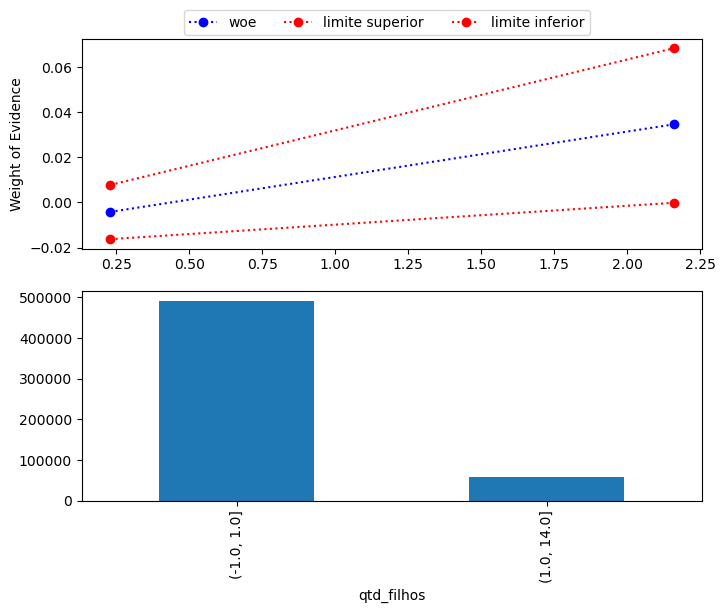

In [26]:
# Realizando o cálculo para a variável 'qtd_filhos'
biv_continua('qtd_filhos', 5, df_metadados)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,265681,17048,0.060298,Assalariado,282729,0.000448,0.061175,0.059421,-2.746263,-2.730883,-2.761855,0.045066,0.060446,0.029474
Bolsista,248,10,0.038760,Bolsista,258,0.012017,0.062424,0.015095,-3.210844,-2.709348,-4.178158,-0.419515,0.081981,-1.386829
Empresário,119389,7135,0.056392,Empresário,126524,0.000649,0.057664,0.055121,-2.817375,-2.793737,-2.841519,-0.026046,-0.002408,-0.050190
Pensionista,87128,5593,0.060321,Pensionista,92721,0.000782,0.061853,0.058788,-2.745862,-2.719143,-2.773225,0.045466,0.072186,0.018104
Servidor público,45767,2001,0.041890,Servidor público,47768,0.000917,0.043687,0.040093,-3.129916,-3.086045,-3.175625,-0.338587,-0.294716,-0.384296


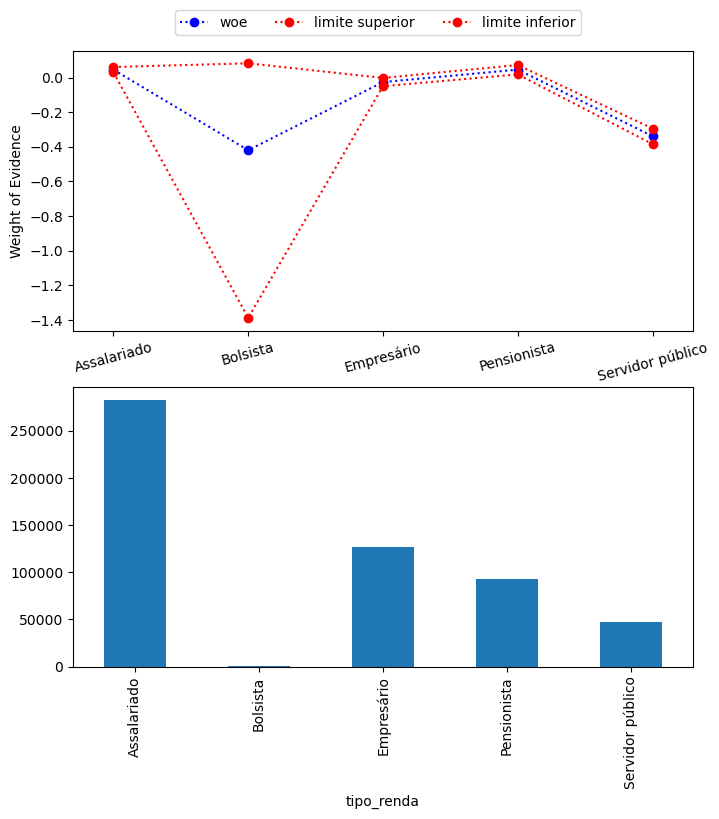

In [27]:
# Realizando o cálculo para a variável 'tipo_renda'
biv_discreta('tipo_renda', df_metadados)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,265681,17048,0.060298,Assalariado,282729,0.000448,0.061175,0.059421,-2.746263,-2.730883,-2.761855,0.045066,0.060446,0.029474
Empresário,119389,7135,0.056392,Empresário,126524,0.000649,0.057664,0.055121,-2.817375,-2.793737,-2.841519,-0.026046,-0.002408,-0.050190
Pensionista,87128,5593,0.060321,Pensionista,92721,0.000782,0.061853,0.058788,-2.745862,-2.719143,-2.773225,0.045466,0.072186,0.018104
Serv._Publ./Bolsista,46015,2011,0.041873,Serv._Publ./Bolsista,48026,0.000914,0.043665,0.040082,-3.130335,-3.086571,-3.175928,-0.339006,-0.295242,-0.384599


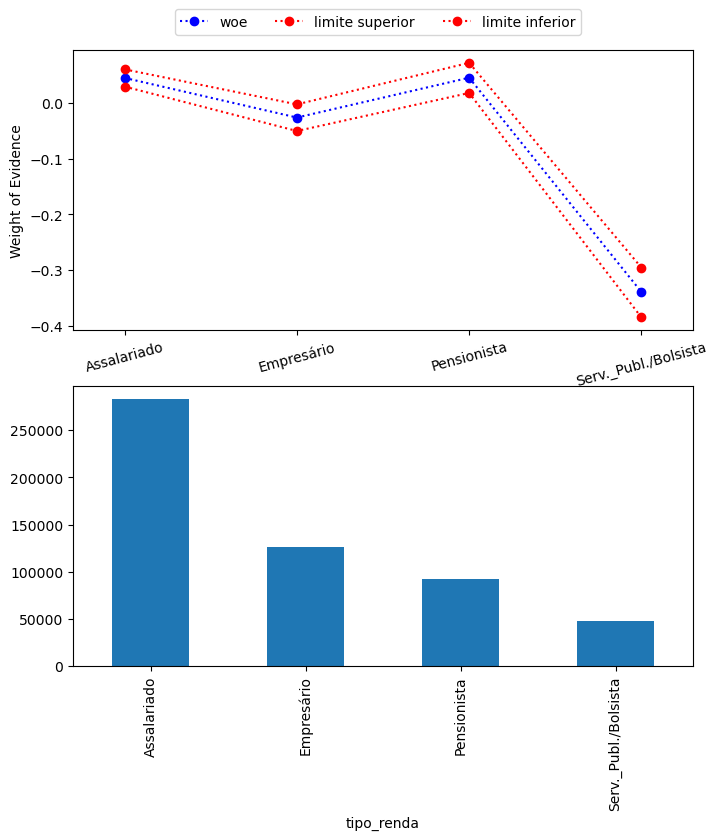

In [28]:
# Ajustando as categorias (juntando Bolsista a Servidor Público)
df_metadados2 = df_metadados.copy()
df_metadados2['tipo_renda'] = df_metadados2.tipo_renda.replace({'Bolsista':'Serv._Publ./Bolsista', 'Servidor público': 'Serv._Publ./Bolsista'})
biv_discreta('tipo_renda', df_metadados2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,5914,417,0.065866,Fundamental,6331,0.003117,0.071978,0.059755,-2.651991,-2.556700,-2.755886,0.139337,0.234629,0.035443
Médio,349470,22115,0.059515,Médio,371585,0.000388,0.060276,0.058755,-2.760162,-2.746652,-2.773834,0.031167,0.044677,0.017495
Pós graduação,564,37,0.061564,Pós graduação,601,0.009805,0.080820,0.042309,-2.724136,-2.431264,-3.119535,0.067193,0.360065,-0.328206
Superior completo,142005,7896,0.052675,Superior completo,149901,0.000577,0.053806,0.051544,-2.889506,-2.867070,-2.912401,-0.098177,-0.075741,-0.121072
Superior incompleto,20260,1322,0.061255,Superior incompleto,21582,0.001632,0.064454,0.058055,-2.729503,-2.675176,-2.786550,0.061826,0.116153,0.004779


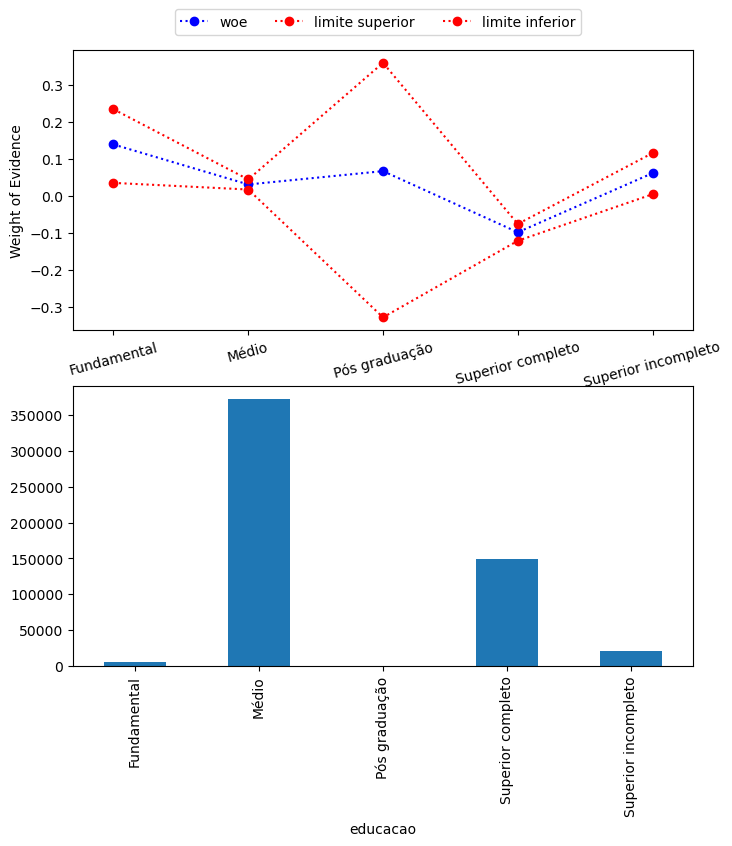

In [29]:
# Realizando o cálculo para a variável 'educacao'
biv_discreta('educacao', df_metadados2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fund./Medio,355384,22532,0.059622,Fund./Medio,377916,0.000385,0.060377,0.058867,-2.758262,-2.744877,-2.771808,0.033067,0.046452,0.019521
Pos./Sup. Completo,142569,7933,0.052710,Pos./Sup. Completo,150502,0.000576,0.053839,0.051581,-2.888795,-2.866411,-2.911636,-0.097466,-0.075082,-0.120307
Superior incompleto,20260,1322,0.061255,Superior incompleto,21582,0.001632,0.064454,0.058055,-2.729503,-2.675176,-2.786550,0.061826,0.116153,0.004779


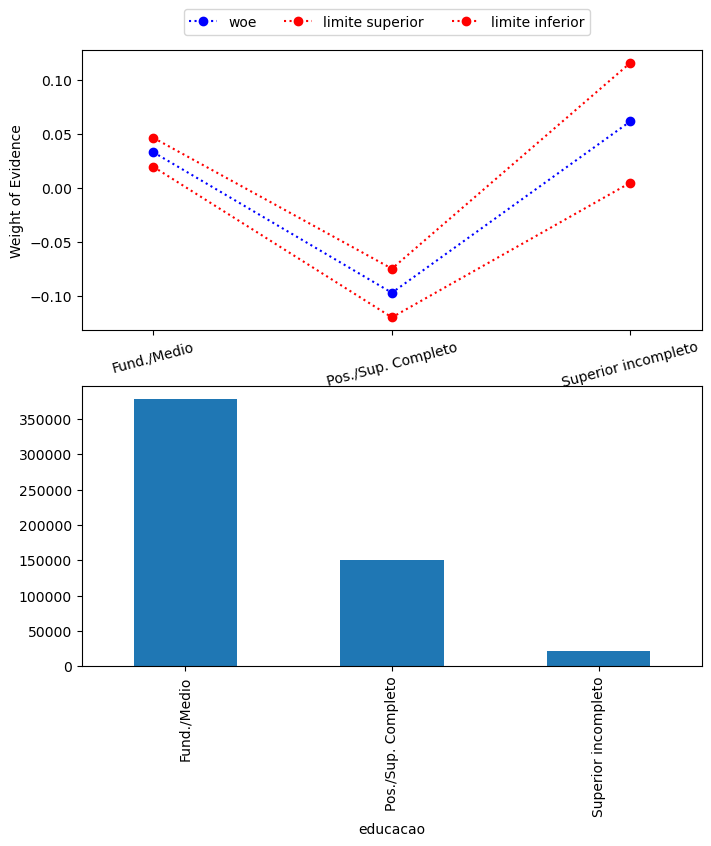

In [30]:
# Ajustando as categorias (juntando Fundamental a Médio e Pós graduação a Superior completo)
df_metadados2['educacao'] = df_metadados2.educacao.replace({'Fundamental':'Fund./Medio', 'Médio': 'Fund./Medio',
                                                           'Pós graduação': 'Pos./Sup. Completo', 'Superior completo': 'Pos./Sup. Completo'})
biv_discreta('educacao', df_metadados2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,364299,21939,0.056802,Casado,386238,0.000372,0.057532,0.056072,-2.809709,-2.796166,-2.823417,-0.018380,-0.004837,-0.032088
Separado,29429,1885,0.060197,Separado,31314,0.001344,0.062831,0.057562,-2.748053,-2.702411,-2.795604,0.043276,0.088918,-0.004275
Solteiro,62974,4010,0.059865,Solteiro,66984,0.000917,0.061662,0.058068,-2.753931,-2.722448,-2.786310,0.037398,0.068880,0.005019
União,39540,2671,0.063277,União,42211,0.001185,0.065600,0.060955,-2.694860,-2.656330,-2.734732,0.096469,0.134999,0.056597
Viúvo,21971,1282,0.055133,Viúvo,23253,0.001497,0.058066,0.052199,-2.841302,-2.786347,-2.899083,-0.049973,0.004981,-0.107754


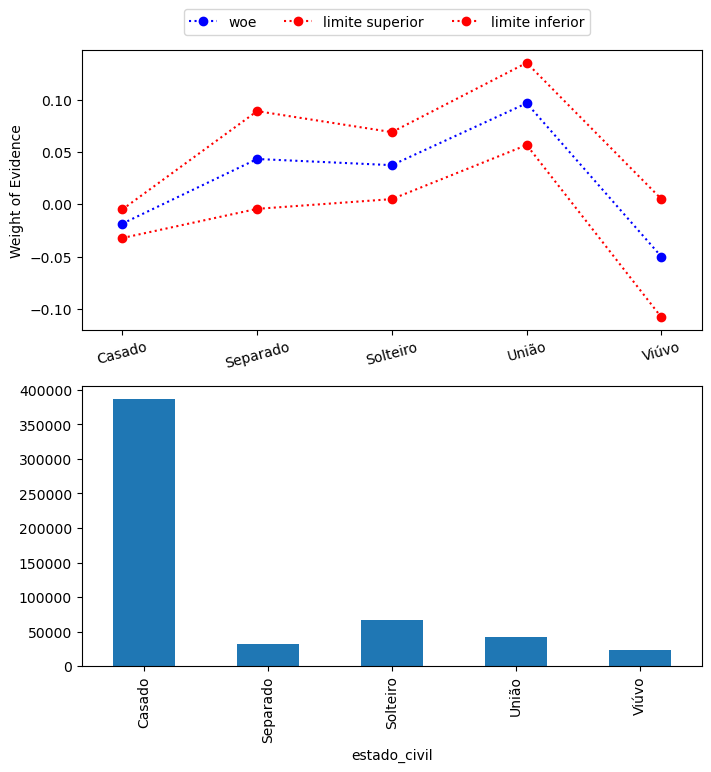

In [31]:
# Realizando o cálculo para a variável 'estado_civil'
biv_discreta('estado_civil', df_metadados2)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,6998,529,0.070280,Aluguel,7527,0.002946,0.076056,0.064505,-2.582391,-2.497182,-2.674338,0.208938,0.294147,0.116991
Casa,466263,28147,0.056930,Casa,494410,0.000330,0.057576,0.056285,-2.807309,-2.795343,-2.819404,-0.015980,-0.004014,-0.028075
Com os pais,22792,1727,0.070435,Com os pais,24519,0.001634,0.073638,0.067232,-2.580024,-2.532102,-2.630004,0.211305,0.259227,0.161325
Comunitário,2274,164,0.067268,Comunitário,2438,0.005073,0.077216,0.057320,-2.629429,-2.480787,-2.800070,0.161900,0.310542,-0.008741
Estúdio,3743,195,0.049518,Estúdio,3938,0.003457,0.056295,0.042740,-2.954643,-2.819200,-3.108949,-0.163314,-0.027871,-0.317620
Governamental,16143,1025,0.059704,Governamental,17168,0.001808,0.063249,0.056160,-2.756794,-2.695345,-2.821759,0.034535,0.095984,-0.030430


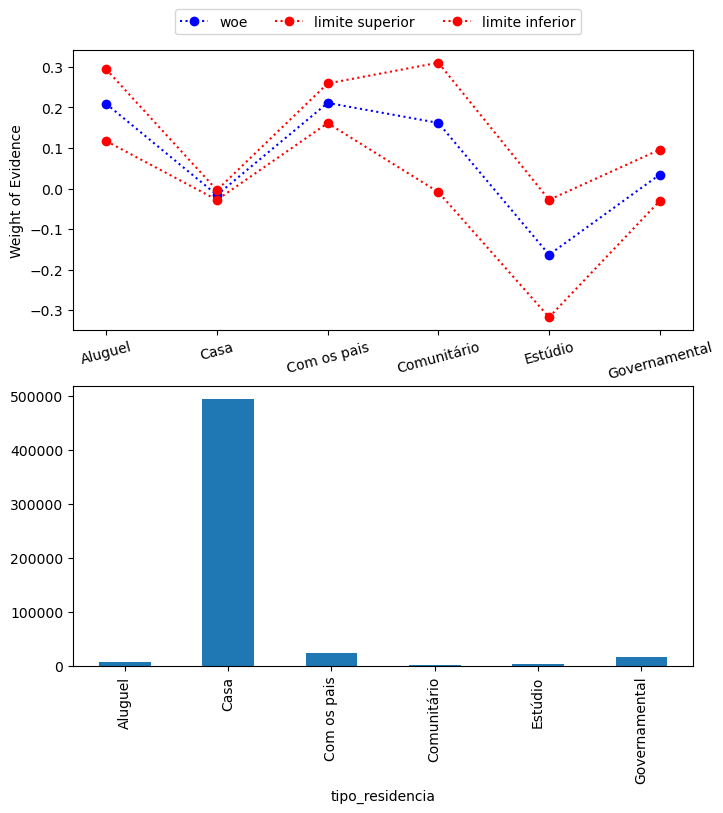

In [32]:
# Realizando o cálculo para a variável 'tipo_residencia'
biv_discreta('tipo_residencia', df_metadados2)

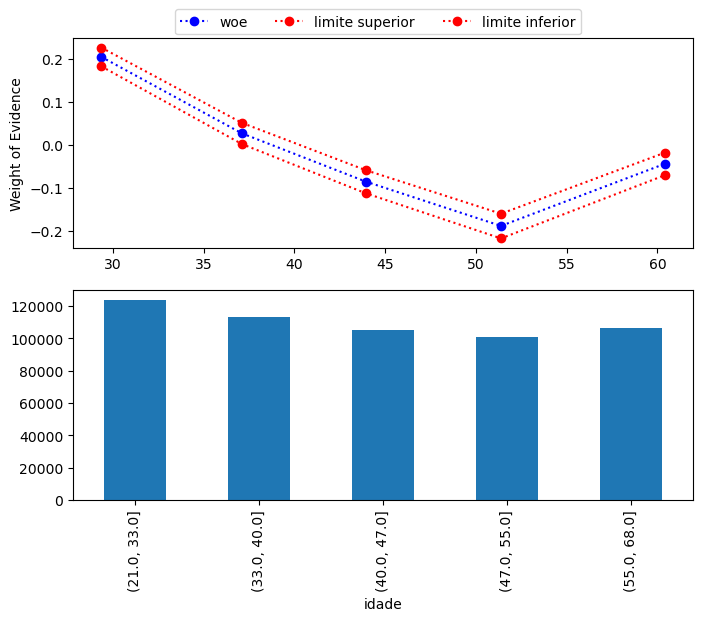

In [33]:
# Realizando o cálculo para a variável 'idade'
biv_continua('idade', 5, df_metadados2)

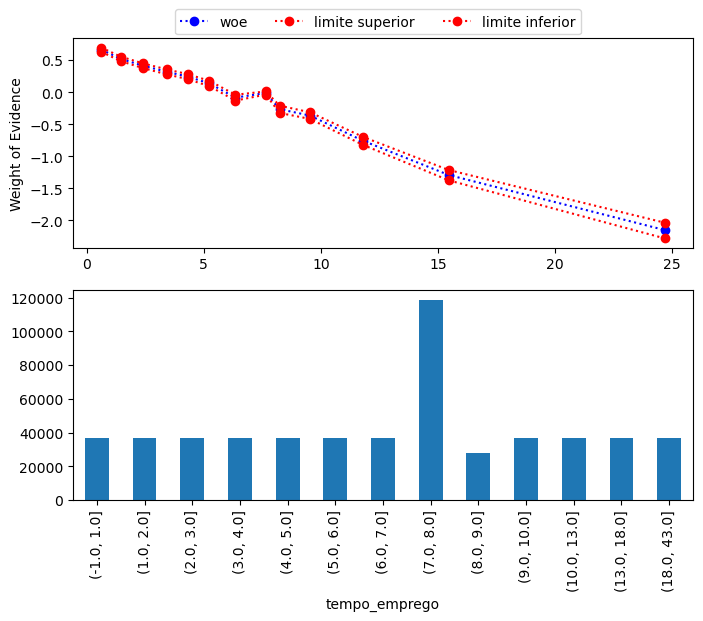

In [34]:
# Realizando o cálculo para a variável 'tempo_emprego'
biv_continua('tempo_emprego', 15, df_metadados2)

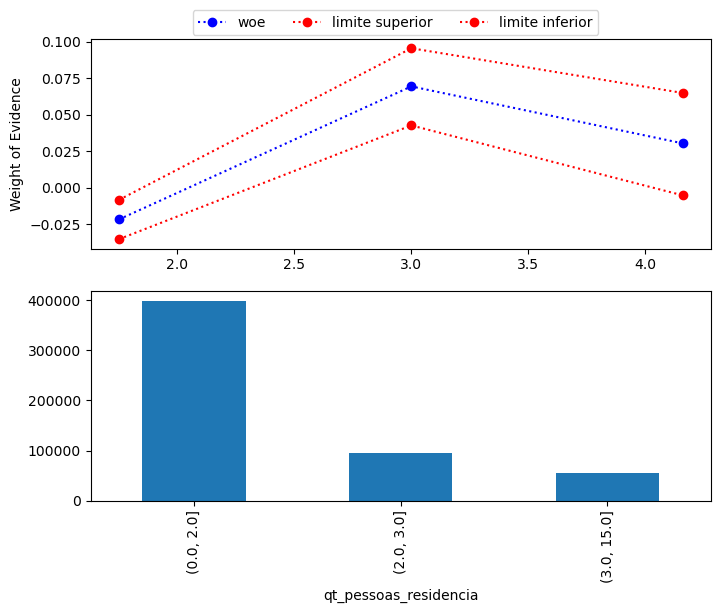

In [35]:
# Realizando o cálculo para a variável 'qt_pessoas_residencia'
biv_continua('qt_pessoas_residencia', 5, df_metadados2)

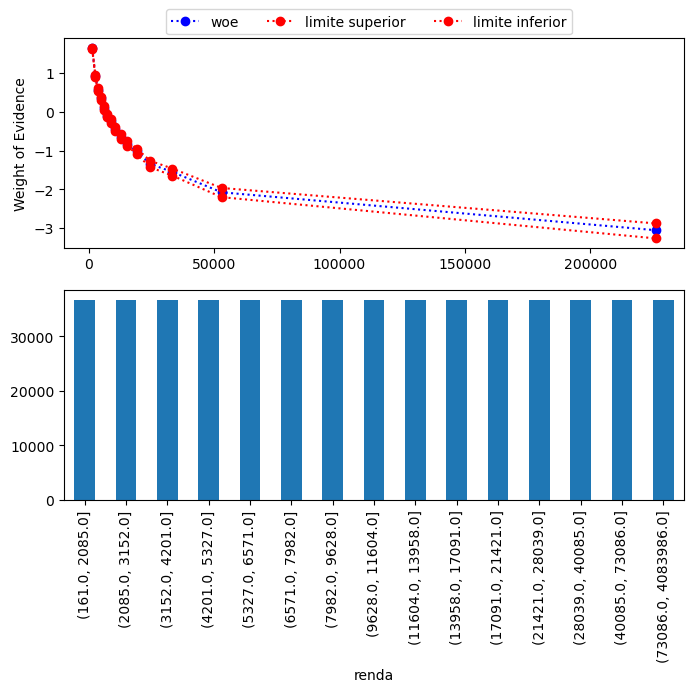

In [36]:
# Realizando o cálculo para a variável 'renda'
biv_continua('renda', 15, df_metadados2)

In [37]:
# ajuda para definir a equação da regressão
' + '.join(list(df_metadados2.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [38]:
# Desenvolvendo o modelo
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + 
    estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=df_metadados2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549977
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1006e+05
Date:                Sat, 01 Jun 2024   Deviance:                   2.2002e+05
Time:                        13:51:15   Pearson chi2:                 9.68e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04063
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.2728      0.202     -6.307      0.000      -1.668      -0.877
sexo[T.M]                             -0.1168      0.014     -8.318      0.000      -0.144      -0.089
posse_de_veiculo[T.S]                  0.0324      0.013      2.444      0.015       0.006       0.058
posse_de_imovel[T.S]                  -0.0843      0.013     -6.667      0.000      -0.109      -0.059
tipo_renda[T.Empresário]              -0.0501      0.015     -3.346      0.001      -0.079      -0.021
tipo_renda[T.Pensionista]             -0.0577      0.022     -2.657      0.008      -0.100      -0.015
tipo_renda[T.Serv._Publ./Bolsista]    -0.0488      0.025     -1.959      0.050      -0.098    1.76e-05
educacao[T.Pos./Sup. Completo]        -0.0562      0.014     -3.959      0.000      -0.084      -0.028
educacao[T.Superior incompleto]       -0.0484      0.030     -1.597      0.110      -0.108       0.011
estado_civil[T.Separado]              -0.0592      0.100     -0.591      0.554      -0.256       0.137
estado_civil[T.Solteiro]              -0.0782      0.098     -0.797      0.425      -0.270       0.114
estado_civil[T.União]                  0.0578      0.022      2.662      0.008       0.015       0.100
estado_civil[T.Viúvo]                 -0.1214      0.102     -1.192      0.233      -0.321       0.078
tipo_residencia[T.Casa]               -0.1206      0.047     -2.580      0.010      -0.212      -0.029
tipo_residencia[T.Com os pais]        -0.1121      0.053     -2.128      0.033      -0.215      -0.009
tipo_residencia[T.Comunitário]        -0.1607      0.095     -1.700      0.089      -0.346       0.025
tipo_residencia[T.Estúdio]            -0.0700      0.088     -0.795      0.426      -0.243       0.103
tipo_residencia[T.Governamental]      -0.1241      0.057     -2.186      0.029      -0.235      -0.013
qtd_filhos                             0.0952      0.097      0.980      0.327      -0.095       0.286
idade                                  0.0005      0.001      0.609      0.543      -0.001       0.002
tempo_emprego                         -0.0215      0.002    -11.140      0.000      -0.025      -0.018
qt_pessoas_residencia                 -0.0884      0.097     -0.912      0.362      -0.278       0.102
renda                              -9.788e-05   1.11e-06    -88.256      0.000      -0.000   -9.57e-05
======================================================================================================
"""

In [39]:
# Ordenando o metadados pelo IV
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,111722.0,covariavel,0.951802
tempo_emprego,float64,0.0,3005.0,covariavel,0.282848
idade,int64,0.0,47.0,covariavel,0.018253
tipo_renda,object,0.0,5.0,covariavel,0.010233
posse_de_imovel,object,0.0,2.0,covariavel,0.009829
educacao,object,0.0,5.0,covariavel,0.003578
tipo_residencia,object,0.0,6.0,covariavel,0.003411
sexo,object,0.0,2.0,covariavel,0.002323
estado_civil,object,0.0,5.0,covariavel,0.001366
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001291


In [40]:
# Refazendo o modelo com IV acima de 0.009, retirando idade que não está representativo
formula = '''
    mau ~ posse_de_imovel + tipo_renda + tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_metadados2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549993
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1011e+05
Date:                Sat, 01 Jun 2024   Deviance:                   2.2012e+05
Time:                        13:51:32   Pearson chi2:                 9.92e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04045
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.5849      0.014   -110.298      0.000      -1.613      -1.557
posse_de_imovel[T.S]                  -0.0798      0.012     -6.493      0.000      -0.104      -0.056
tipo_renda[T.Empresário]              -0.0488      0.015     -3.292      0.001      -0.078      -0.020
tipo_renda[T.Pensionista]             -0.0331      0.017     -1.932      0.053      -0.067       0.000
tipo_renda[T.Serv._Publ./Bolsista]    -0.0561      0.025     -2.268      0.023      -0.105      -0.008
tempo_emprego                         -0.0206      0.002    -10.812      0.000      -0.024      -0.017
renda                              -9.884e-05   1.11e-06    -89.375      0.000      -0.000   -9.67e-05
======================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [41]:
# Avaliando na base de desenvolvimento
df_metadados2['score'] = rl.predict(df_metadados2)

# Acurácia
acc = metrics.accuracy_score(df_metadados2.mau, df_metadados2.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_metadados2.mau, df_metadados2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_metadados2.loc[df_metadados2.mau == 1, 'score'], df_metadados2.loc[df_metadados2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 61.4% 
AUC: 76.7% 
GINI: 53.3%
KS: 39.4%


<span style="color:blue; font-size:20px">Conclusão para a base de desenvolvimento:</span>

<font color='blue'>- A Acurácia indica que aproximadamente 61.4% das previsões do seu modelo estão corretas;</font>

<font color='blue'>- O AUC indica que o modelo tem um bom poder discriminativo;</font>

<font color='blue'>- O GINI também sugere que o modelo está razoavelmente bom em separar as classes; e</font>

<font color='blue'>- O KS indica que há uma diferença significativa entre essas distribuições.</font> 

In [42]:
# Ajustando a base *out of time*
df_validacao = df_validacao.drop(columns = ['data_ref', 'index'])
media = df_validacao['tempo_emprego'].mean()
df_validacao['tempo_emprego'] = df_validacao['tempo_emprego'].copy().fillna(media)
df_validacao['tipo_renda'] = df_validacao.tipo_renda.replace({'Bolsista':'Serv._Publ./Bolsista', 
                                                              'Servidor público': 'Serv._Publ./Bolsista'})
df_validacao['educacao'] = df_validacao.educacao.replace({'Fundamental':'Fund./Medio', 'Médio': 'Fund./Medio',
                                                           'Pós graduação': 'Pos./Sup. Completo', 
                                                          'Superior completo': 'Pos./Sup. Completo'})
df_validacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 583335 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   200000 non-null  object 
 1   posse_de_veiculo       200000 non-null  object 
 2   posse_de_imovel        200000 non-null  object 
 3   qtd_filhos             200000 non-null  int64  
 4   tipo_renda             200000 non-null  object 
 5   educacao               200000 non-null  object 
 6   estado_civil           200000 non-null  object 
 7   tipo_residencia        200000 non-null  object 
 8   idade                  200000 non-null  int64  
 9   tempo_emprego          200000 non-null  float64
 10  qt_pessoas_residencia  200000 non-null  float64
 11  renda                  200000 non-null  float64
 12  mau                    200000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 21.4+ MB


In [44]:
# Avaliando na base *out of time*
df_validacao['score'] = rl.predict(df_validacao)

# Acurácia
acc = metrics.accuracy_score(df_validacao.mau, df_validacao.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_validacao.mau, df_validacao.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_validacao.loc[df_validacao.mau == 1, 'score'], df_validacao.loc[df_validacao.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 33.8% 
AUC: 73.3% 
GINI: 46.5%
KS: 34.2%


<span style="color:blue; font-size:20px">Conclusão para a base de validação:</span>

<font color='blue'>Houve queda em todos os indicadores abaixo para a base de validação:</font>

<font color='blue'>- A Acurácia indica que aproximadamente 33.8% das previsões do seu modelo estão corretas;</font>

<font color='blue'>- O AUC indica que o modelo tem um poder discriminativo razoável;</font>

<font color='blue'>- O GINI também sugere que o modelo está razoavelmente bom em separar as classes; e</font>

<font color='blue'>- O KS indica que há alguma separação entre as distribuições, mas não é muito significativa.</font> 